In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from time import time
from oracle import Oracle, make_oracle
from line_search import line_search_nesterov
from optimize_methods import optimize_gd

In [5]:
def six_plots(res, names=None, compare_name="параметров"):

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(17,6))
    for i in range(len(res)):
        ax1.plot(res[i][2], np.log10(res[i][1]))                
        ax1.legend(names)
        ax1.set_ylabel("log(L(w))")
        ax1.set_xlabel("iteration")
        ax1.set_title("Сходимость от итераций для разных " + compare_name)
        ax1.grid(which='both',
                color = 'gray',
                linestyle = ':')
  
    for i in range(len(res)):
        ax2.plot(res[i][2], np.log10(np.abs(res[i][5])))
                    
        ax2.legend(names)
        ax2.set_ylabel("log(||grad(L(w))||)")
        ax2.set_xlabel("iteration")
        ax2.set_title("Сходимость от итераций для разных " + compare_name)
        ax2.grid(which='both',
                color = 'gray',
                linestyle = ':')
        f.show()


    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(17,6))
    for i in range(len(res)):
        ax1.plot(res[i][3], np.log10(res[i][1]))                  
        ax1.legend(names)
        ax1.set_ylabel("log(L(w))")
        ax1.set_xlabel("oracle calls")
        ax1.set_title("Сходимость от вызовов оракула для разных " + compare_name)
        ax1.grid(which='both',
                color = 'gray',
                linestyle = ':')
  
    for i in range(len(res)):
        ax2.plot(res[i][3], np.log10(np.abs(res[i][5])))
                    
        ax2.legend(names)
        ax2.set_ylabel("log(||grad(L(w))||)")
        ax2.set_xlabel("oracle calls")
        ax2.set_title("Сходимость от вызовов оракула для разных " + compare_name)
        ax2.grid(which='both',
                color = 'gray',
                linestyle = ':')
        f.show()



    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(17,6))
    for i in range(len(res)):
        ax1.plot(res[i][4], np.log10(res[i][1]))                 
    ax1.legend(names)
    ax1.set_ylabel("log(L(w))")
    ax1.set_xlabel("time, s")
    ax1.set_title("Сходимость от времени для разных " + compare_name)
    ax1.grid(which='both',
            color = 'gray',
            linestyle = ':')
  
    for i in range(len(res)):
        ax2.plot(res[i][4], np.log10(np.abs(res[i][5])))
                    
    ax2.legend(names)
    ax2.set_ylabel("log(||grad(L(w))||)")
    ax2.set_xlabel("time, s")
    ax2.set_title("Сходимость от времени для разных " + compare_name)
    ax2.grid(which='both',
            color = 'gray',
            linestyle = ':')
    f.show()

Создадим 3 оракула для трёх разных датасетов.

In [6]:
oracle1 = make_oracle("a1a.txt")
oracle2 = make_oracle("breast_cancer_scale.txt")

Используем проксимальный градиентный метод для минимизации функции вида
$$\varphi(x) = f(x) + h(x),$$
где $\varphi$ -- непрерывнодифференцируема, а $h(x) = \lambda||x||_1$ - выпуклая.


Итерация проксимального метода

$$x_{k + 1} = Prox_h^{\alpha_k}(x_k - \alpha_k \nabla f(x_k))$$

Длина шага $\alpha_k$ будет подбираться с помощью схемы Нестерова, с которой мы уже знакомы. Однако условием остановки в данной схеме будет:

$$\varphi(y) \le f(x) + \nabla f(x)^T (y - x) + \dfrac{L}{2} ||y - x||^2_2 + h(y)$$

но так как $\varphi(y) = f(y) + h(y)$, то слагаемое $h(y)$ входит с обеих сторон, поэтому его можно сократить.

В следующей ячейке определим проксимальный оператор и оптимизирующую функцию.

In [9]:
def arg_min_prox(x, a, lam):
    w = np.copy(x)
    mask1 = x < -lam * a
    mask2 = x > lam * a
    mask3 = np.logical_and(x >= -lam * a, x <= lam * a)
    w[mask1] += lam * a
    w[mask2] -= lam * a
    w[mask3] = 0
    return w

def optimize_lasso(oracle, start_point, lam=10**(-2), tol=10**(-8), max_iter=10000, stata=False):
    L = 1
    w = np.copy(start_point)
    y = np.copy(w)
    
    oracle_call = 0
    time0 = time()

    values = []
    iterations = []
    oracle_calls = []
    times = []
    grads = []
    
    for k in range(max_iter):
        y0 = np.copy(y)
        value_f0, grad_f0 = oracle.fuse_value_grad(y0)
        oracle_call += 1
        a = 1 / L
        y = arg_min_prox(y0 - a * grad_f0, a, lam)
        value_f = oracle.value(y)
        oracle_call += 1
        
        while value_f > value_f0 + grad_f0.T @ (y - y0) + (y - y0).T @ (y - y0) * L / 2:
            L *= 2 
            a = 1 / L
            y = arg_min_prox(y0 - a * grad_f0, a, lam)
            value_f = oracle.value(y)
            oracle_call += 1

        gradF = (w - y) * L
        L /= 2
        w = np.copy(y)
        
        values.append(oracle.value_with_reg(w, lam)[0][0])  # графики будут с регуляризатором
        iterations.append(k + 1)
        oracle_calls.append(oracle_call)
        times.append(time() - time0)
        grads.append((gradF.T @ gradF)[0][0])
        
        stop_criteria = gradF.T @ gradF <= tol
        if stop_criteria:
            break
        
    if stata:
        return w, values, iterations, oracle_calls, times, grads
    return w

Для начала сравним работу обычного градиентного спуска и только что определённой функции с коэффициентом регуляризации равным 0.

In [10]:
oracle = oracle1

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []

# GD
optimize = optimize_gd()
line_search_method = line_search_nesterov()
w_my = optimize(oracle, w0, line_search_method, tol=10**(-16))
vals = optimize.values
iters = optimize.iterations
or_calls = optimize.oracle_calls
times = optimize.times
grads = optimize.grads
res.append([w_my, [x[0][0] for x in vals], iters, or_calls, times, grads])


# lass0 (lam = 0)
w_my, vals, iters, or_calls, times, grads = optimize_lasso(oracle, 
                                                           w0, lam=0,
                                                           tol=10**(-16),
                                                           stata=True)
res.append([w_my, vals, iters, or_calls, times, grads])

iteration: 1000
value of CE: 0.30504281392341565
norm(d)^2 / norm(d_0)^2: 3.5926792737446114e-06
alpha 2.0

iteration: 2000
value of CE: 0.30200451675672213
norm(d)^2 / norm(d_0)^2: 1.3407859106583918e-06
alpha 1.0

iteration: 3000
value of CE: 0.30077144425330893
norm(d)^2 / norm(d_0)^2: 1.1974025114687877e-06
alpha 4.0

iteration: 4000
value of CE: 0.3000927535376653
norm(d)^2 / norm(d_0)^2: 3.6619448372284387e-07
alpha 2.0

iteration: 5000
value of CE: 0.2996597056561948
norm(d)^2 / norm(d_0)^2: 3.400826628153238e-07
alpha 2.0

iteration: 6000
value of CE: 0.29936749983683647
norm(d)^2 / norm(d_0)^2: 1.7513286779934005e-07
alpha 1.0

iteration: 7000
value of CE: 0.2991582216938435
norm(d)^2 / norm(d_0)^2: 3.543418556206783e-07
alpha 4.0

iteration: 8000
value of CE: 0.29900113739454526
norm(d)^2 / norm(d_0)^2: 1.1380633760586465e-07
alpha 2.0

iteration: 9000
value of CE: 0.29887926979325136
norm(d)^2 / norm(d_0)^2: 1.6421729021086132e-07
alpha 4.0

break


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI b

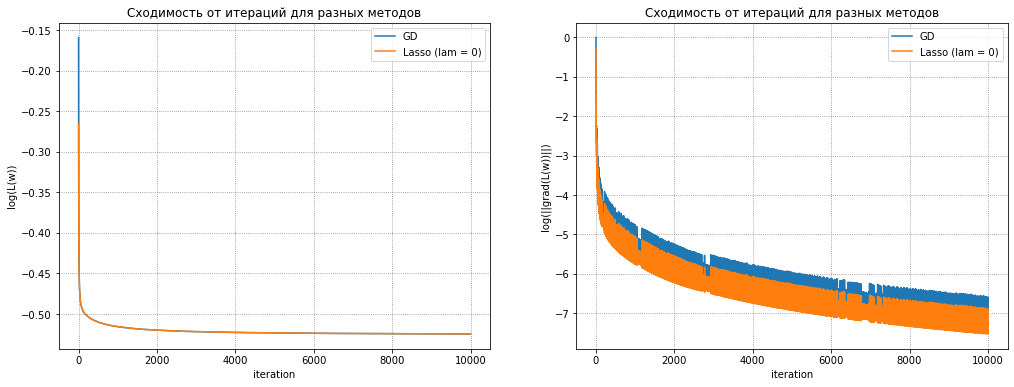

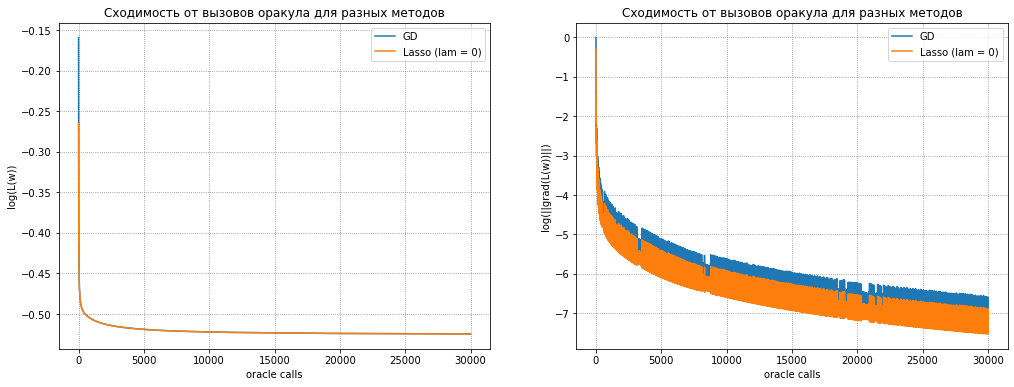

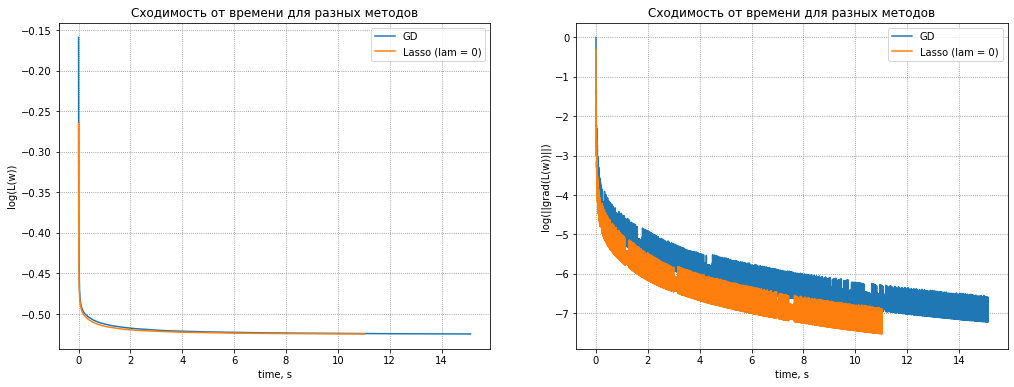

In [11]:
six_plots(res, names=["GD", "Lasso (lam = 0)"], compare_name="методов")

In [12]:
print("Gradient Descent --  CE-value: {:1.7f},  time: {:1.5f},  iters: {:5}, oracle calls: {:5}"
      .format(res[0][1][-1], res[0][4][-1], res[0][2][-1], res[0][3][-1]))

print("Lasso (lam = 0)  --  CE-value: {:1.7f},  time: {:1.5f},  iters: {:5}, oracle calls: {:5}"
      .format(res[1][1][-1], res[1][4][-1], res[1][2][-1], res[1][3][-1]))

Gradient Descent --  CE-value: 0.2987821,  time: 15.11502,  iters:  9999, oracle calls: 29995
Lasso (lam = 0)  --  CE-value: 0.2987820,  time: 11.03000,  iters: 10000, oracle calls: 29998


И графики и статистики оптимизационного процесса очень похожи, то есть в случае $\lambda = 0$ мы получаем обычный градиентный спуск. Можно также отметить, что GD работал на 5 сек. дольше.

## Исследования
Изучить работу метода на нескольких наборах данных, влияние параметра регуляризаци на скорость сходимости
метода и количество ненулевых параметров в решении, постоим графики по значению оптимизируемой функции и критерия
остановки в зависимости от итерации (и не только).

In [13]:
# a1a dataset

oracle = oracle1
lams = [0, 10**(-7), 10**(-6), 10**(-5), 10**(-4),
        10**(-3), 10**(-2), 10**(-1), 1]

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
nzw = []
for lam in lams:
    w_my, vals, iters, or_calls, times, grads = optimize_lasso(oracle, w0, lam=lam, tol=10**(-16), stata=True)
    non_zero_weights = np.sum(np.abs(w_my) > 0)
    nzw.append(non_zero_weights)
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print("lambda: {:7},  CE-value: {:1.7f},  non-zero weights: {:3},  iters: {:5}"
          .format(lam, vals[-1], non_zero_weights, iters[-1]))

lambda:       0,  CE-value: 0.2987820,  non-zero weights: 114,  iters: 10000
lambda:   1e-07,  CE-value: 0.2987948,  non-zero weights: 113,  iters: 10000
lambda:   1e-06,  CE-value: 0.2989163,  non-zero weights: 110,  iters: 10000
lambda:   1e-05,  CE-value: 0.3000652,  non-zero weights: 107,  iters: 10000
lambda:  0.0001,  CE-value: 0.3087186,  non-zero weights:  89,  iters: 10000
lambda:   0.001,  CE-value: 0.3445816,  non-zero weights:  47,  iters:  8778
lambda:    0.01,  CE-value: 0.4415489,  non-zero weights:  13,  iters:   368
lambda:     0.1,  CE-value: 0.6326148,  non-zero weights:   1,  iters:    28
lambda:       1,  CE-value: 0.6931472,  non-zero weights:   0,  iters:     1


С ростом коэффициента регуляризации количество ненулевых весов уменьшается. Причём начиная с $\lambda = 0.001$ количество итераций начало снижаться относительно органичения по итерациям (10000), а следовательно и время работы уменьшается. При $\lambda = 1$ нулевых весов вообще не оказалось.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI b

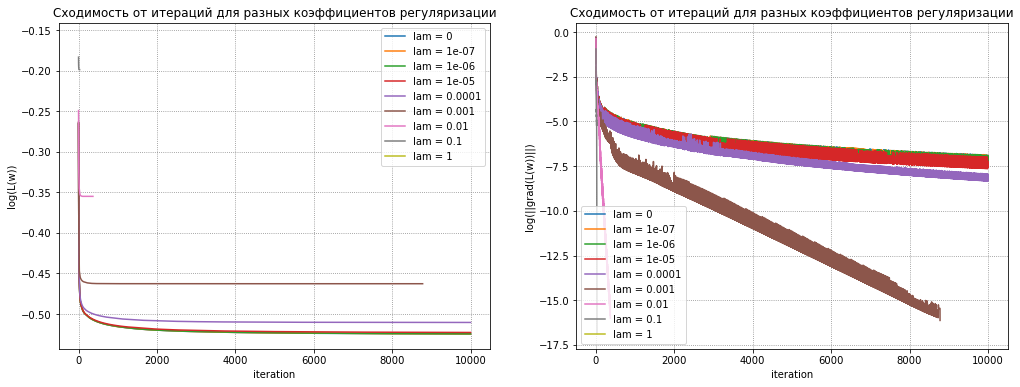

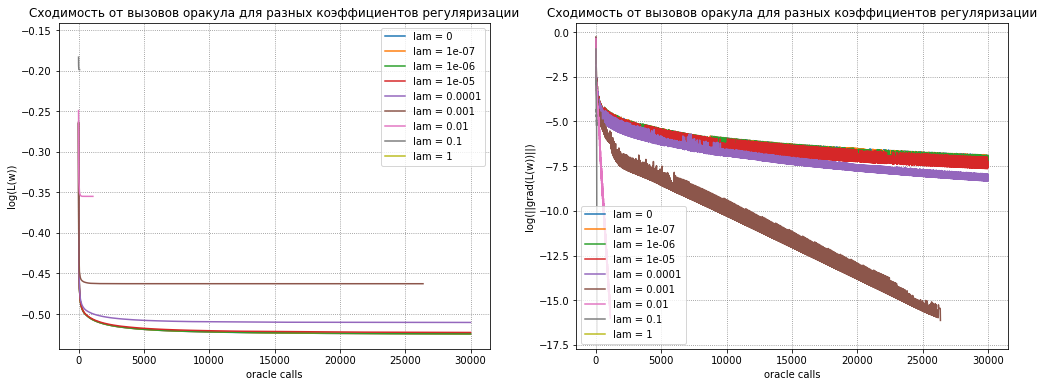

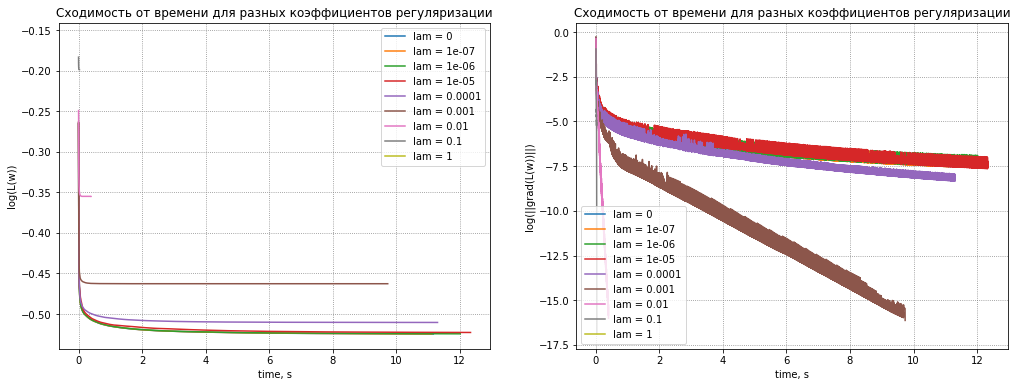

In [14]:
six_plots(res, names=list(map(lambda x: "lam = " + str(x), lams)), compare_name="коэффициентов регуляризации")

При большом коэффициенте ($\lambda = 1, 0.1$) кривые $\log(L(w))$ получились совсем короткими, что согласовано с тем что величина критерия остановки быстро достигает заданной точности. Для $\lambda = 0.01, 0.001$ кривые $\log(L(w))$ уже длиннее, но всё равно оптимизационный процесс для них завершается быстрее чем за 10 тыс. итераций. Для оставшейся группы коэффициентов регуляризации (маленькой величины) оптимизация проходила схожим образом и с ними процесс завершился достижением максимального количества итераций.

In [15]:
# bc dataset

oracle = oracle2
lams = [0, 10**(-7), 10**(-6), 10**(-5), 10**(-4),
        10**(-3), 10**(-2), 10**(-1), 1]

# w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
nzw = []
for lam in lams:
    w_my, vals, iters, or_calls, times, grads = optimize_lasso(oracle, w0, lam=lam, tol=10**(-16), stata=True)
    non_zero_weights = np.sum(np.abs(w_my) > 0)
    nzw.append(non_zero_weights)
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print("lambda: {:7},  CE-value: {:1.7f},  non-zero weights: {:3},  iters: {:5}"
          .format(lam, vals[-1], non_zero_weights, iters[-1]))

lambda:       0,  CE-value: 0.0753187,  non-zero weights:  11,  iters: 10000
lambda:   1e-07,  CE-value: 0.0753206,  non-zero weights:  11,  iters: 10000
lambda:   1e-06,  CE-value: 0.0753377,  non-zero weights:  11,  iters: 10000
lambda:   1e-05,  CE-value: 0.0755054,  non-zero weights:  10,  iters:  4488
lambda:  0.0001,  CE-value: 0.0771289,  non-zero weights:   9,  iters:  3649
lambda:   0.001,  CE-value: 0.0909990,  non-zero weights:  10,  iters:  1352
lambda:    0.01,  CE-value: 0.1753613,  non-zero weights:   8,  iters:   277
lambda:     0.1,  CE-value: 0.4709018,  non-zero weights:   3,  iters:   125
lambda:       1,  CE-value: 0.6931472,  non-zero weights:   0,  iters:     3


Вновь с ростом коэффициента регуляризации количество ненулевых весов уменьшается (правда для $\lambda = 0.001$ количество ненулевых весов увеличилось на 1 по сравнению с предыдущим коэффициентом регуляризации). Начиная с $\lambda = 1e-05$ количество итераций начало снижаться относительно органичения по итерациям (10000), а следовательно и время работы уменьшается. При $\lambda = 1$ нулевых весов снова не оказалось.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI b

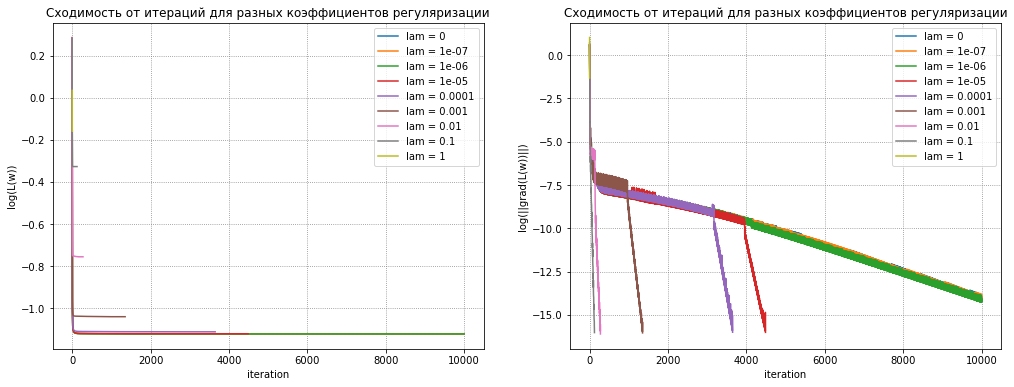

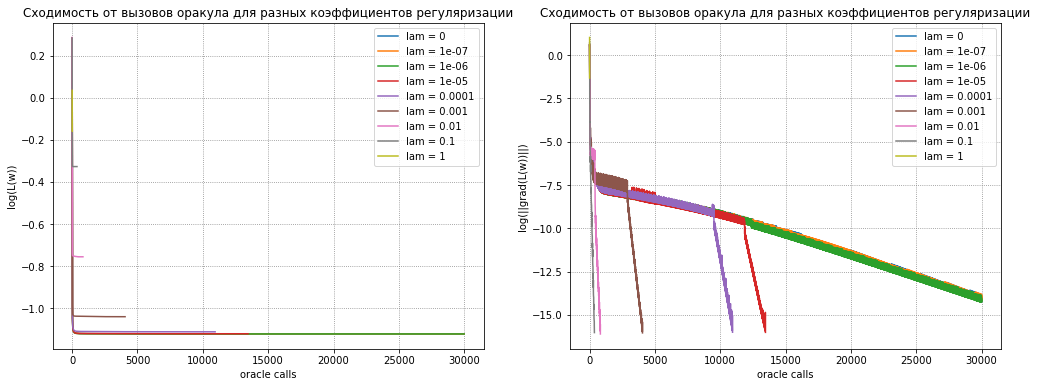

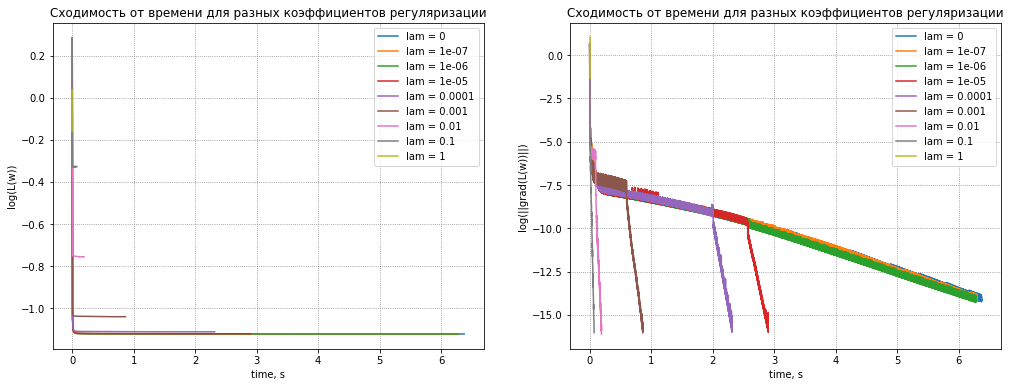

In [16]:
six_plots(res, names=list(map(lambda x: "lam = " + str(x), lams)), compare_name="коэффициентов регуляризации")

Аналогично эксперименту на предыдущем датасете графики вновь демонстрируют то, как с уменьшением коэффициента регуляризации время/количество итераций оптимизационного процесса растёт.